<a href="https://colab.research.google.com/github/RaphaelCarvalh/BootCampAVANTI_machine_learning/blob/ativ04-et01-analise-dataset/Et01_analise_dataset_fase2_pr%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto Clothing Co-Parsing - Etapa 1 - Notebook: Análise do Dataset - TIV-04-ET-02


In [ ]:
# ============================================================
# Projeto Clothing Co-Parsing - Notebook Principal (Professor)
# ============================================================

# 1. Instalação de pacotes necessários
print("Instalando pacotes necessários...")
!pip install opendatasets pandas matplotlib opencv-python pillow --quiet
print("Pacotes instalados com sucesso.\n")

# 2. Importações iniciais
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time, copy, json
from tqdm import tqdm

print("Pacotes importados com sucesso.\n")

# Otimização no CUDA
torch.backends.cudnn.benchmark = True


Instalando pacotes necessários...
Pacotes instalados com sucesso.



In [2]:
# 3. Montar Google Drive e carregar dataset já limpo
from google.colab import drive
drive.mount('/content/drive')

LOAD_PATH = "/content/drive/MyDrive/ClothingDataset/df_clean.csv"
df = pd.read_csv(LOAD_PATH)

print("Exemplo do dataset carregado:")
print(df.head())
print(f"Total de imagens: {len(df)}\n")

# Número de classes
num_classes = len(df['label'].unique())
print(f"Número de classes: {num_classes}")


Mounted at /content/drive
Exemplo do dataset carregado:
                                     image_path  corrupted        image_hash  \
0  ./clothing-coparsing-dataset/images/0391.jpg      False  b19bcb72550cccf0   
1  ./clothing-coparsing-dataset/images/1465.jpg      False  8e2e7b911476a969   
2  ./clothing-coparsing-dataset/images/1312.jpg      False  f18081ff763ac4f0   
3  ./clothing-coparsing-dataset/images/1842.jpg      False  b14e84b14c9aae6f   
4  ./clothing-coparsing-dataset/images/0983.jpg      False  b4ccdbb30489bcb4   

   width  height  channels        label  
0    550     824         3  pixel-level  
1    550     809         3  image-level  
2    550     832         3  image-level  
3    550     809         3  image-level  
4    550     827         3  pixel-level  
Total de imagens: 2096

Número de classes: 2


In [3]:
# 4. Transformações e Augmentations
print("Configurando transformações e augmentations...\n")

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Transformações configuradas com sucesso.")


Configurando transformações e augmentations...

Transformações configuradas com sucesso.


In [4]:
# 5. Dataset personalizado
class ClothingDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx, 0], self.data[idx, 1]
        img = cv2.imread(img_path)
        if img is None:
            # fallback para imagens corrompidas
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# 6. Split em treino, validação, teste
train_data, temp_data = train_test_split(df.values, test_size=0.2, random_state=42, stratify=df.values[:,1])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data[:,1])

# Criar datasets
train_ds = ClothingDataset(train_data, transform=train_transform)
val_ds = ClothingDataset(val_data, transform=val_test_transform)
test_ds = ClothingDataset(test_data, transform=val_test_transform)

# Criar dataloaders
BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Treino: {len(train_ds)} | Validação: {len(val_ds)} | Teste: {len(test_ds)}")


Treino: 1676 | Validação: 210 | Teste: 210


In [45]:
def train_model(
    model,
    train_dl,
    val_dl,
    criterion,
    optimizer,
    num_epochs=10,
    device=None,
    save_path="best_model.pth",
    early_stopping_patience=None,
    grad_clip=None,
    use_amp=True
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(1, num_epochs+1):
        print(f"\nÉpoca {epoch}/{num_epochs}")
        start_time = time.time()

        # ---------- Treino ----------
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_dl, desc="Treinando", leave=False):
            #inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            inputs, labels = inputs.to(device), labels.detach().clone().to(device, dtype=torch.long)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                if grad_clip:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                if grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            preds = torch.argmax(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels).item()
            total += inputs.size(0)

        epoch_loss = train_loss / total
        epoch_acc = train_correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # ---------- Validação ----------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_dl:
                #inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
                inputs, labels = inputs.to(device), labels.detach().clone().to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_correct += torch.sum(preds == labels).item()
                val_total += inputs.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Salvar melhor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            patience_counter = 0
            print(f" Melhor modelo salvo em {save_path}")
        else:
            patience_counter += 1
            if early_stopping_patience and patience_counter >= early_stopping_patience:
                print(" Early stopping ativado.")
                break

        print(f" Tempo da época: {(time.time()-start_time):.1f}s")

    model.load_state_dict(best_model_wts)
    return model, history, best_val_acc


transformações e augmentations

In [1]:
# 6. Definição dos modelos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ResNet50
resnet50 = models.resnet50(weights="IMAGENET1K_V1")
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, num_classes)
resnet50 = resnet50.to(device)

# EfficientNet-B0
efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, num_classes)
efficientnet = efficientnet.to(device)

print("Modelos inicializados com sucesso.")

# Critério de perda
criterion = nn.CrossEntropyLoss()

# ---------- Treinar ResNet50 ----------
optimizer_resnet = optim.Adam(resnet50.parameters(), lr=1e-4)
print("\n Treinando ResNet50...")
resnet50, history_resnet, best_acc_resnet = train_model(
    model=resnet50,
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer_resnet,
    num_epochs=10,
    device=device,
    save_path="best_resnet50.pth",
    early_stopping_patience=3
)

# Exportar ResNet50
EXPORT_PATH = "/content/drive/MyDrive/ClothingDataset/TrainedModels"
os.makedirs(EXPORT_PATH, exist_ok=True)

import shutil
try:
    shutil.copy2("/content/best_resnet50.pth", os.path.join(EXPORT_PATH, "best_resnet50.pth"))
    print("ResNet50 exportado com sucesso ✅")
except Exception as e:
    print(f"Erro ao exportar ResNet50: {e}")

# ---------- Treinar EfficientNet-B0 ----------
optimizer_efficient = optim.Adam(efficientnet.parameters(), lr=1e-4)
print("\n Treinando EfficientNet-B0...")
efficientnet, history_efficient, best_acc_efficient = train_model(
    model=efficientnet,
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer_efficient,
    num_epochs=10,
    device=device,
    save_path="best_efficientnet.pth",
    early_stopping_patience=3
)

# Exportar EfficientNet-B0
try:
    shutil.copy2("/content/best_efficientnet.pth", os.path.join(EXPORT_PATH, "best_efficientnet.pth"))
    print("EfficientNet-B0 exportado com sucesso ✅")
except Exception as e:
    print(f"Erro ao exportar EfficientNet: {e}")

# ---------- Comparação da Acurácia ----------
plt.figure(figsize=(10,5))
plt.plot(history_resnet['val_acc'], label="ResNet50")
plt.plot(history_efficient['val_acc'], label="EfficientNet-B0")
plt.title("Comparação da Acurácia de Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

print("\n Resultados finais:")
print(f"ResNet50 - Melhor Val Acc: {best_acc_resnet:.4f}")
print(f"EfficientNet-B0 - Melhor Val Acc: {best_acc_efficient:.4f}")


NameError: name 'torch' is not defined

In [6]:
# 6. Definição dos modelos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ResNet50
resnet50 = models.resnet50(weights="IMAGENET1K_V1")
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, num_classes)
resnet50 = resnet50.to(device)

# EfficientNet-B0
efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, num_classes)
efficientnet = efficientnet.to(device)

# VGG16
vgg16 = models.vgg16(weights="IMAGENET1K_V1")
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features, num_classes)
vgg16 = vgg16.to(device)

print("Modelos inicializados com sucesso.")


Usando dispositivo: cpu
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 72.7MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 37.7MB/s]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:11<00:00, 49.6MB/s]


Modelos inicializados com sucesso.


Criar Datasets e DataLoaders

In [7]:
# Critério de perda
criterion = nn.CrossEntropyLoss()

# Treinar ResNet50
optimizer_resnet = optim.Adam(resnet50.parameters(), lr=1e-4)
print("\n Treinando ResNet50...")
resnet50, history_resnet, best_acc_resnet = train_model(
    model=resnet50,
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer_resnet,
    num_epochs=10,
    device=device,
    save_path="best_resnet50.pth",
    early_stopping_patience=3
)






 Treinando ResNet50...

Época 1/10


Train Loss: 0.0636 | Train Acc: 0.9809
Val Loss: 0.0363 | Val Acc: 1.0000
✅ Melhor modelo salvo em best_resnet50.pth
⏱️ Tempo da época: 1287.3s

Época 2/10


Train Loss: 0.0012 | Train Acc: 1.0000
Val Loss: 0.0010 | Val Acc: 1.0000
⏱️ Tempo da época: 1234.7s

Época 3/10


Train Loss: 0.0008 | Train Acc: 1.0000
Val Loss: 0.0007 | Val Acc: 1.0000
⏱️ Tempo da época: 1212.2s

Época 4/10


Train Loss: 0.0006 | Train Acc: 1.0000
Val Loss: 0.0005 | Val Acc: 1.0000
⏹️ Early stopping ativado.


In [8]:
# 7. Exportar modelos para o Google Drive
print("\n Exportando modelos para o Google Drive...")

EXPORT_PATH = "/content/drive/MyDrive/ClothingDataset/TrainedModels"
os.makedirs(EXPORT_PATH, exist_ok=True)

model_files = ["best_resnet50.pth"]

for file_name in model_files:
    source_path = os.path.join("/content/", file_name)
    destination_path = os.path.join(EXPORT_PATH, file_name)
    try:
        # Usar a função copy2 para preservar metadados
        import shutil
        shutil.copy2(source_path, destination_path)
        print(f"'{file_name}' exportado com sucesso para '{EXPORT_PATH}'")
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_name}' não foi encontrado.")
    except Exception as e:
        print(f"Erro ao exportar '{file_name}': {e}")

print("\n Exportação de modelos concluída.")


 Exportando modelos para o Google Drive...
'best_resnet50.pth' exportado com sucesso para '/content/drive/MyDrive/ClothingDataset/TrainedModels'

 Exportação de modelos concluída.


In [12]:
# Treinar VGG16
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=1e-4)
print("\n Treinando VGG16...")
vgg16, history_vgg, best_acc_vgg = train_model(
    model=vgg16,
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer_vgg,
    num_epochs=10,
    device=device,
    save_path="best_vgg16.pth",
    early_stopping_patience=3
)



 Treinando VGG16...

Época 1/10


Train Loss: 0.0137 | Train Acc: 0.9958
Val Loss: 0.0000 | Val Acc: 1.0000
✅ Melhor modelo salvo em best_vgg16.pth
⏱️ Tempo da época: 5805.4s

Época 2/10


Train Loss: 0.0000 | Train Acc: 1.0000
Val Loss: 0.0000 | Val Acc: 1.0000
⏱️ Tempo da época: 3587.3s

Época 3/10


Train Loss: 0.0000 | Train Acc: 1.0000
Val Loss: 0.0000 | Val Acc: 1.0000
⏱️ Tempo da época: 3625.7s

Época 4/10


Train Loss: 0.0000 | Train Acc: 1.0000
Val Loss: 0.0000 | Val Acc: 1.0000
⏹️ Early stopping ativado.


In [13]:
# 7. Exportar modelos para o Google Drive
print("\n Exportando modelos para o Google Drive...")

EXPORT_PATH = "/content/drive/MyDrive/ClothingDataset/TrainedModels"
os.makedirs(EXPORT_PATH, exist_ok=True)

model_files = ["best_vgg16.pth"]

for file_name in model_files:
    source_path = os.path.join("/content/", file_name)
    destination_path = os.path.join(EXPORT_PATH, file_name)
    try:
        # Usar a função copy2 para preservar metadados
        import shutil
        shutil.copy2(source_path, destination_path)
        print(f"'{file_name}' exportado com sucesso para '{EXPORT_PATH}'")
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_name}' não foi encontrado.")
    except Exception as e:
        print(f"Erro ao exportar '{file_name}': {e}")

print("\n Exportação de modelos concluída.")


 Exportando modelos para o Google Drive...
'best_vgg16.pth' exportado com sucesso para '/content/drive/MyDrive/ClothingDataset/TrainedModels'

 Exportação de modelos concluída.


In [10]:
# Treinar EfficientNet-B0
optimizer_efficient = optim.Adam(efficientnet.parameters(), lr=1e-4)
print("\n Treinando EfficientNet-B0...")
efficientnet, history_efficient, best_acc_efficient = train_model(
    model=efficientnet,
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer_efficient,
    num_epochs=10,
    device=device,
    save_path="best_efficientnet.pth",
    early_stopping_patience=3
)



 Treinando EfficientNet-B0...

Época 1/10


Train Loss: 0.1291 | Train Acc: 0.9821
Val Loss: 0.2891 | Val Acc: 1.0000
✅ Melhor modelo salvo em best_efficientnet.pth
⏱️ Tempo da época: 533.3s

Época 2/10


Train Loss: 0.0081 | Train Acc: 1.0000
Val Loss: 0.0272 | Val Acc: 1.0000
⏱️ Tempo da época: 567.6s

Época 3/10


Train Loss: 0.0037 | Train Acc: 1.0000
Val Loss: 0.0123 | Val Acc: 1.0000
⏱️ Tempo da época: 560.8s

Época 4/10


Train Loss: 0.0023 | Train Acc: 1.0000
Val Loss: 0.0031 | Val Acc: 1.0000
⏹️ Early stopping ativado.


In [11]:
# 7. Exportar modelos para o Google Drive
print("\n Exportando modelos para o Google Drive...")

EXPORT_PATH = "/content/drive/MyDrive/ClothingDataset/TrainedModels"
os.makedirs(EXPORT_PATH, exist_ok=True)

model_files = ["best_efficientnet.pth"]

for file_name in model_files:
    source_path = os.path.join("/content/", file_name)
    destination_path = os.path.join(EXPORT_PATH, file_name)
    try:
        # Usar a função copy2 para preservar metadados
        import shutil
        shutil.copy2(source_path, destination_path)
        print(f"'{file_name}' exportado com sucesso para '{EXPORT_PATH}'")
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_name}' não foi encontrado.")
    except Exception as e:
        print(f"Erro ao exportar '{file_name}': {e}")

print("\n Exportação de modelos concluída.")


 Exportando modelos para o Google Drive...
'best_efficientnet.pth' exportado com sucesso para '/content/drive/MyDrive/ClothingDataset/TrainedModels'

 Exportação de modelos concluída.


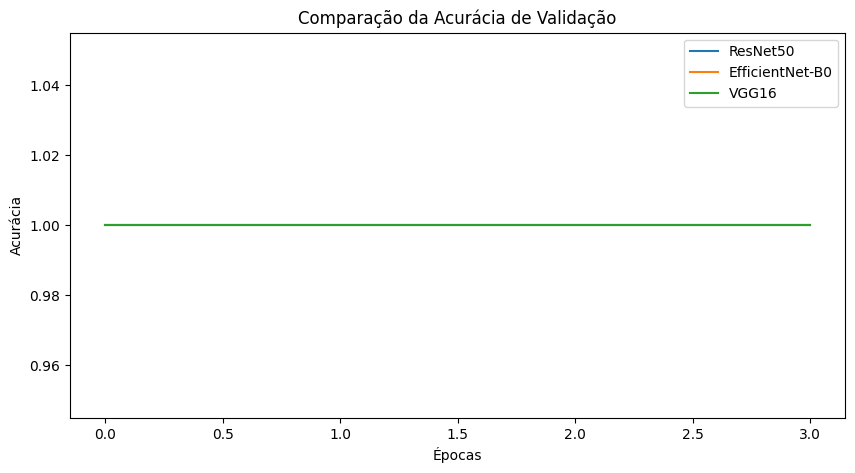


 Resultados finais:
ResNet50 - Melhor Val Acc: 1.0000
EfficientNet-B0 - Melhor Val Acc: 1.0000
VGG16 - Melhor Val Acc: 1.0000


In [32]:
# Comparação da Acurácia de Validação
plt.figure(figsize=(10,5))
plt.plot(history_resnet['val_acc'], label="ResNet50")
plt.plot(history_efficient['val_acc'], label="EfficientNet-B0")
plt.plot(history_vgg['val_acc'], label="VGG16")
plt.title("Comparação da Acurácia de Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

print("\n Resultados finais:")
print(f"ResNet50 - Melhor Val Acc: {best_acc_resnet:.4f}")
print(f"EfficientNet-B0 - Melhor Val Acc: {best_acc_efficient:.4f}")
print(f"VGG16 - Melhor Val Acc: {best_acc_vgg:.4f}")
